# E-commerce Order Lifecycle & Data Quality Analysis

## Objective
This notebook explores an e-commerce dataset to:
- Assess data completeness and quality
- Understand whether missing values indicate data issues or valid business behavior
- Analyze the impact of incomplete product data on customer behavior

The analysis focuses on **business-aware validation**, not blind cleaning.


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("default")

## Data Loading
All datasets are loaded using pandas. No transformations are applied at this stage.


In [30]:
df_customers = pd.read_csv("Customers.csv")
df_sellers = pd.read_csv("Sellers.csv")
df_geolocation = pd.read_csv("geolocation.csv")
df_items = pd.read_csv("Items.csv")
df_order_reviews = pd.read_csv("Order_reviews.csv")
df_orders = pd.read_csv("Orders.csv")
df_payments = pd.read_csv("Payments.csv")
df_cat_translation = pd.read_csv("product_category_name_translation.csv")
df_products = pd.read_csv("Products.csv")


## Dataset Overview
The dataset consists of multiple relational tables representing customers, orders,
products, payments, and logistics.

In [31]:
tables = {
    "Customers": df_customers,
    "Sellers": df_sellers,
    "Geolocation": df_geolocation,
    "Items": df_items,
    "Order Reviews": df_order_reviews,
    "Orders": df_orders,
    "Payments": df_payments,
    "Category Translation": df_cat_translation,
    "Products": df_products
}

overview = pd.DataFrame({
    "Table": tables.keys(),
    "Rows": [df.shape[0] for df in tables.values()],
    "Columns": [df.shape[1] for df in tables.values()],
    "Total Null Values": [df.isnull().sum().sum() for df in tables.values()]
})

overview


,Table,Rows,Columns,Total Null Values
0,Customers,99441,5,0
1,Sellers,3095,4,0
2,Geolocation,1000163,5,0
3,Items,112650,7,0
4,Order Reviews,99224,7,145903
5,Orders,99441,8,4908
6,Payments,103886,5,0
7,Category Translation,71,2,0
8,Products,32951,9,2448


<Axes: title={'center': 'Total Missing Values by Table'}, ylabel='Table'>

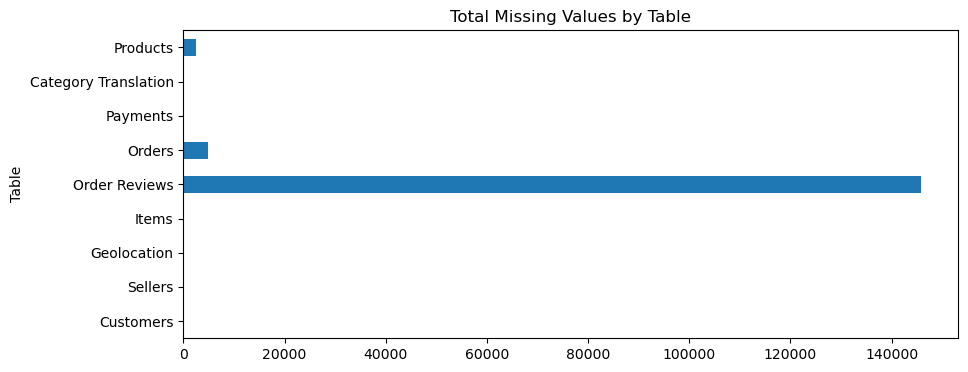

In [32]:
overview.set_index("Table")["Total Null Values"].plot(
    kind="barh",
    title="Total Missing Values by Table",
    figsize=(10,4)
)

## Missing Value Analysis by Order Status

Missing timestamps may represent either:
- genuine data quality issues, or
- valid business behavior depending on order status

To distinguish between the two, missing values are analyzed by `order_status`.


In [33]:
print(df_order_reviews.isnull().sum())
print(df_orders.isnull().sum())

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64


In [34]:
cols = [
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
]

nulls_by_status = (
    df_orders
    .groupby("order_status")[cols]
    .apply(lambda x: x.isna().sum())
)

nulls_by_status


,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date
order_status,,,
approved,0,2,2
canceled,141,550,619
created,5,5,5
delivered,14,2,8
invoiced,0,314,314
processing,0,301,301
shipped,0,0,1107
unavailable,0,609,609


<Axes: title={'center': 'Missing Lifecycle Timestamps by Order Status'}, xlabel='order_status'>

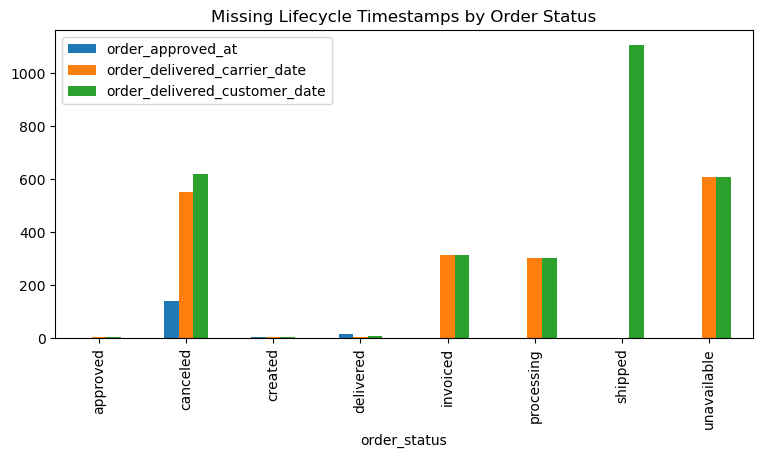

In [35]:
nulls_by_status.plot(
    kind="bar",
    figsize=(9,4),
    title="Missing Lifecycle Timestamps by Order Status"
)


### Key Observations
- Canceled, created, and unavailable orders show high missing delivery timestamps,
  which is expected as these orders do not complete fulfillment.
- Invoiced and processing orders lack delivery timestamps because they precede shipping.
- Shipped orders correctly lack customer delivery timestamps.
- A small number of delivered orders contain missing approval or delivery timestamps,
  which is logically inconsistent.

### Conclusion
Most missing values are **status-driven and valid**.
However, missing fulfillment timestamps in delivered orders indicate potential
data quality issues and should be flagged.


## Product Data Completeness

Products missing core descriptive attributes are flagged as incomplete.


In [36]:
print(df_products.isnull().sum())

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64


In [37]:
df_products["is_product_incomplete"] = (
    df_products[
        [
            "product_category_name",
            "product_name_lenght",
            "product_description_lenght",
            "product_photos_qty"
        ]
    ]
    .isnull()
    .any(axis=1)
)
df_products["is_product_incomplete"].value_counts()


is_product_incomplete
False    32341
True       610
Name: count, dtype: int64

Text(0, 0.5, 'Product Information Status')

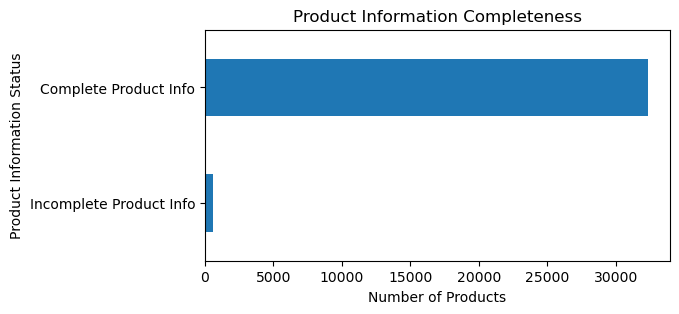

In [38]:
product_completeness = (
    df_products["is_product_incomplete"]
    .map({False: "Complete Product Info", True: "Incomplete Product Info"})
    .value_counts()
)

product_completeness.sort_values().plot(
    kind="barh",
    figsize=(6,3),
    title="Product Information Completeness"
)

plt.xlabel("Number of Products")
plt.ylabel("Product Information Status")


## Impact of Incomplete Product Data on Customer Behavior
The analysis evaluates whether incomplete product information affects:
- average orders per customer
- proportion of one-time customers


In [39]:
orders_items_products = (
    df_orders
    .merge(df_items, on="order_id", how="left")
    .merge(df_products, on="product_id", how="left")
    .merge(df_customers[["customer_id", "customer_unique_id"]], on="customer_id", how="left")
)


In [40]:
customer_order_counts = (
    orders_items_products
    .groupby("customer_unique_id")["order_id"]
    .nunique()
    .reset_index(name="order_count")
)

orders_items_products = orders_items_products.merge(
    customer_order_counts,
    on="customer_unique_id",
    how="left"
)

orders_items_products["is_one_time_customer"] = (
    orders_items_products["order_count"] == 1
)


In [41]:
orders_items_products.groupby("is_product_incomplete")["order_count"].mean()


is_product_incomplete
False    1.083865
True     1.092327
Name: order_count, dtype: float64

In [42]:
orders_items_products.groupby("is_product_incomplete")["is_one_time_customer"].mean()


is_product_incomplete
False    0.932740
True     0.938241
Name: is_one_time_customer, dtype: float64

## Final Insights
- Incomplete product metadata has a **negligible impact** on repeat purchasing behavior.
- Customer retention is driven more by fulfillment experience than product description completeness.
- Data quality efforts should prioritize order lifecycle integrity over product text enrichment.

## Recommendations
- Enforce validation rules for delivered orders
- Apply status-aware null handling during ETL
- Exclude pre-fulfillment orders from delivery SLA metrics


## Customer Repeat Purchase Distribution (Context)

Before interpreting repeat purchase drivers, it is important to understand the
baseline customer behavior in the OLIST marketplace.

The vast majority of customers place only a single order, with repeat purchases
being extremely rare. This creates a structural limitation when analyzing
retention-related metrics.


In [43]:
customer_order_dist = (
    customer_order_counts["order_count"]
    .value_counts(normalize=True)
    .sort_index() * 100
)

customer_order_dist


order_count
1     96.881244
2      2.856518
3      0.211247
4      0.031219
5      0.008325
6      0.006244
7      0.003122
9      0.001041
17     0.001041
Name: proportion, dtype: float64

<Axes: title={'center': 'Distribution of Orders per Customer (%)'}, ylabel='order_count'>

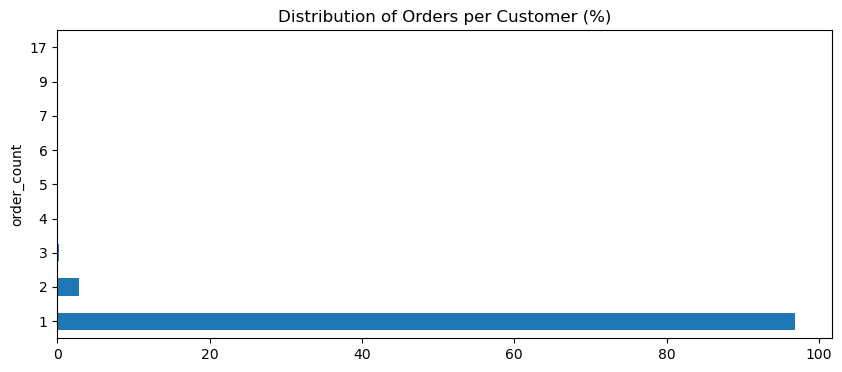

In [44]:
customer_order_dist.plot(
    kind="barh",
    figsize=(10,4),
    title="Distribution of Orders per Customer (%)"
)


### Why No Strong Effect Is Observed

Although product description completeness shows little variation in repeat
purchase behavior, this result must be interpreted in the context of the
overall customer distribution.

With approximately 97% of customers making only a single purchase, the dataset
offers limited variance to detect meaningful drivers of repeat behavior.
As a result, many potentially influential factors appear statistically neutral.

This does not imply that product descriptions are unimportant, but rather that
repeat purchase is not the appropriate outcome variable in this marketplace.
